# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: This is a classification problem. This is because the output will be classifing students into two categories, e.g. 'intervention needed' and 'no intervention needed'

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [15]:
# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features (subtract 1 for 'passed' column)
n_features = student_data.shape[1] - 1

# TODO: Calculate passing students
n_passed = student_data.loc[student_data['passed'] == 'yes'].shape[0]

# TODO: Calculate failing students
n_failed = student_data.loc[student_data['passed'] == 'no'].shape[0]

# TODO: Calculate graduation rate
grad_rate = 100. * n_passed * 1./n_students

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

from sklearn.metrics import f1_score
print "\nF1 score for predicting all 'yes': {:.4f}".format(
    f1_score(y_true = ['yes']*n_passed + ['no']*n_failed, y_pred = ['yes']*n_students, pos_label='yes', average='binary'))

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%

F1 score for predicting all 'yes': 0.8030


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

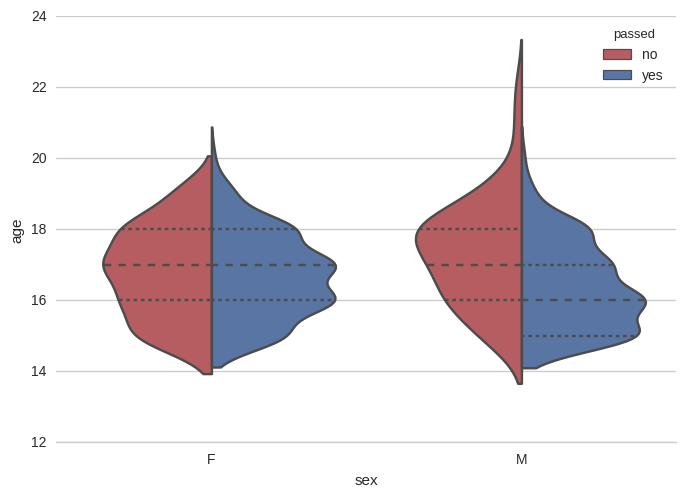

In [18]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="sex", y="age", hue="passed", data=student_data, split=True, 
               inner="quart", palette={"yes": "b", "no": "r"})
sns.despine(left=True)

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [6]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
#X_train = X_all.sample(frac=1. *num_train/n_students, random_state=200)
#X_test = X_all.drop(X_train.index)
#y_train = y_all[X_train.index]
#y_test = y_all.drop(y_train.index)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=95, random_state=42, stratify=y_all)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: The first model I am choosing is a Decision Tree. One real-world application of a Decision Tree is by Environmental Sciences Europe for evaluating risks posed by combined exposures to multiple chemicals (https://enveurope.springeropen.com/articles/10.1186/2190-4715-24-34). Decision Trees strengths include the fact that they are relatively easy to interpret and can be useful even with little training data. One of the weaknesses of DTs are that they can be prone to overfitting and also can become very large for data that has categorical variables. I think a Decision Tree is a good candidate for this problem as our data has been massages to suit DTs (binary variables, dummy variables) and also they are easy to interpret and visualize, so a DT would be a good first candidate.

The second model I am choosing is a Support Vector Machine. One real-world application of a Support Vector Machine is form the Chinese Journal of Aeronautics for Gas Turbine Performance Diagnosis (http://www.sciencedirect.com/science/article/pii/S1000936111602768). Advantages of Support Vector Machines are that you can build in domain knowldege through the kernel. They weaknesses of SVMs are that they can be very slow to train and the decision of kernel to use is critical. I think a Support Vector Machine is a good candidate for this problem as they can be used for a wide variety of applications, and they are effective in high dimensional spaces. We have 30 different features here, so it may be a good choice.

The third model I am choosing is Gaussian Naive Bayes. One real-world application of GaussianNB is for Heart Disease Prediction (http://www.ijarcce.com/upload/2014/may/IJARCCE9E%20%20a%20rupali%20%20Heart%20Disease%20Prediction.pdf). A strength of GaussianNB is that it only requires a small dataset to estimate classification parameters, and it also can be very fast. A weakness of GaussianNB is that is is typically a poor estimator, so not very useful for regressions. I think GaussianNB is a good candidate for this problem as we have a relatively small input dataset, and this is a strength of the GaussianNB classifier.

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [7]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.


DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0014 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.6452.
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0019 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.7258.
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0028 seconds
Made predictions in 0.0006 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0004 seconds.
F1 score for test set: 0.6838.

SVC: 

Training a SVC using a training set size of 100. . .
Trained model in 0.0019 seconds
Made predictions in 0.0014 seconds.
F1 score for training set: 0.8354.
Made predictions in 0.0013 seconds.
F1 score for test set: 0.8025.
Training a SVC u

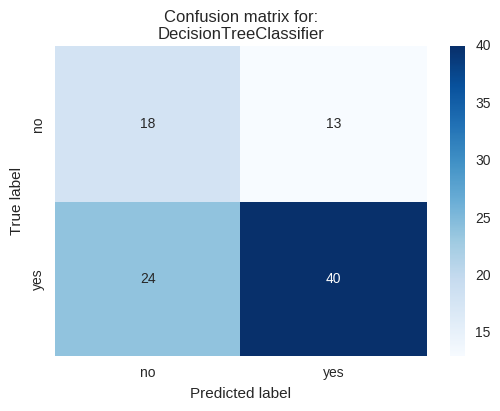

In [25]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
# from sklearn import model_B
# from skearln import model_C
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_A = tree.DecisionTreeClassifier(random_state=42)
clf_B = svm.SVC(random_state=42)
clf_C = GaussianNB()

# TODO: Set up the training set sizes
X_train_100 = X_train[0:100]
y_train_100 = y_train[0:100]

X_train_200 = X_train[0:200]
y_train_200 = y_train[0:200]

X_train_300 = X_train
y_train_300 = y_train

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for clf in [clf_A, clf_B, clf_C]:
    print "\n{}: \n".format(clf.__class__.__name__)
    for n in [100, 200, 300]:
        train_predict(clf, X_train[:n], y_train[:n], X_test,  y_test)
        

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Compute confusion matrix for a model
model = clf_A
cm = confusion_matrix(y_test.values, model.predict(X_test))

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(modelA.__class__.__name__));

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - DecisionTree  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0018s           |         0.0003s        |       1.0        |     0.6452      |
| 200               |        0.0018s          |          0.0003s        |       1.0           |     0.7258            |
| 300               |        0.0022s           |         0.0002s        |       1.0           |    0.6838      |

** Classifer 2 - SVM  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |      0.0015s            |       0.0009s          |        0.8354  |     0.8025            |
| 200               |      0.0046s             |      0.0023s          |        0.8431          |    0.8105             |
| 300               |      0.0101s             |      0.0026s          |        0.8664          |     0.8052     |

** Classifer 3 - GaussianNB

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |       0.0009s           |       0.0004s          |       0.7752     |     0.6457            |
| 200               |       0.0013s           |       0.0005s          |       0.8060           |     0.7218            |
| 300               |       0.0015s           |       0.0004s          |       0.8134           |     0.7761            |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: Based on the results shown in the table above, we can see that using a GuassianNB classifier is the best model to pick. It can train the model quickest of all the classifiers, and it can run a prediction pretty fast too, just behind the DecisionTree. 

While the F1 Scores for the training set are lower than the others, it is important that the testing F1 Scores are better than the DecisionTree, while approaching the scores of the SVM as we add more data. This will ensure  a more accurate prediction for un-seen or new data. 

Looking ahead, if we had more data, the GaussianNB would scale better to the limited resources that we have. The training time is linear with the amount of samples, as opposed to the SVM which is increasing exponentially.

For these reasons, I am choosing to use the GaussianNB classifier for this problem.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: Here is a description of how the Naive Bayes Model works.

Let's say that we have data on 1000 pieces of fruit. They happen to be Banana, Orange or some Other Fruit. We know 3 characteristics about each fruit:

    Whether it is Long
    Whether it is Sweet and
    If its color is Yellow.

This is our 'training set.' We will use this to predict the type of any new fruit we encounter.

We can also pre-compute some things about our fruit collection.

1/ The so-called "Prior" probabilities. These are our base probabilities; that is, if we didn't know any of the fruit attributes, this would be our guess. Lets imagine these were:

 P(Banana)      = 0.5 
 P(Orange)      = 0.3
 P(Other Fruit) = 0.2

2/ Probability of "Evidence". These are the probabilities of each feature occuring in our training set, for example:

p(Long)   = 0.5
P(Sweet)  = 0.65
P(Yellow) = 0.8

3/ Probability of "Likelihood". These are the probabilites that relate our features to our fruits, for example:

P(Long|Banana) = 0.8
P(Long|Orange) = 0  [Oranges are never long in all the fruit we have seen.]
 ....
P(Yellow|Other Fruit)     =  50/200 = 0.25
P(Not Yellow|Other Fruit) = 0.75

So now, given a new Fruit, how would we classify it? We are told that the fruit is Long, Sweet and Yellow. 

We can simply run the numbers for each of the 3 outcomes, one by one. Then we choose the highest probability and 'classify' our unknown fruit as belonging to the class that had the highest probability based on our prior evidence (our training set).

For example, the probability that it is a Banana would be:

P(Banana|Long, Sweet and Yellow) 
      P(Long|Banana) * P(Sweet|Banana) * P(Yellow|Banana) * P(banana)
    = _______________________________________________________________
                      P(Long) * P(Sweet) * P(Yellow)

We would then classify our fruit  as the fruit with the highest probability.


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [40]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit

# TODO: Create the parameters list you wish to tune
parameters = {'kernel':('linear', 'rbf', 'sigmoid')}
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-4, 2, 7)
class_weight = ['balanced', {'yes': 0.4, 'no': 0.6}]
#parameters = dict(gamma=gamma_range, C=C_range, class_weight=class_weight)

# NOTE TO GRADER : It does not appear that there are any parameters for a GaussianNB
# that I can tune, so I will do the excercise use an SVM instead

# TODO: Initialize the classifier
clf = svm.SVC(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label = 'yes')

# Create a stratified shuffle object
ssscv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.1)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer, cv=ssscv)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print clf

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
Made predictions in 0.0061 seconds.
Tuned model has a training F1 score of 0.8664.
Made predictions in 0.0019 seconds.
Tuned model has a testing F1 score of 0.8052.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: The final models F1 score is 0.8052 which is exactly the same as the untuned model. This would suggest that the untuned model was already using the best value for the 'kernel' parameter.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.